In [1]:
import os
import math
from pathlib import Path
import IPython
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.data import load_metadata, find_paths

from load_data import *
from feature_selection import *
from data_preprocessing import *
from train_ml_model import *
from tarin_dl_model import *
from plot_feature_model import *

import warnings
warnings.filterwarnings("ignore")

4 actual GPUs, 4 in use.


In [2]:
opensmile_uri="/unix/cdtdisspotify/index/opensmile"
yamnet_scores_uri="/unix/cdtdisspotify/index/yamnet/scores"
metadata_path="/unix/cdtdisspotify/data/spotify-podcasts-2020/metadata.tsv"
labeled_path ="/unix/cdtdisspotify/index/labeled.csv"
sample_rate=44100

In [3]:
metadata = load_csv_data(metadata_path, sep='\t')
labeled_data = load_csv_data(labeled_path)

In [4]:
labeled_data = labeled_data.loc[:, ['uri','timestamp', 'entertaining', 'discussion', 'subjective']]
labeled_data['timestamp'] = labeled_data['timestamp'].map(lambda x: str(x))
labeled_data_concat = labeled_data['uri'].str.cat(labeled_data['timestamp'], sep='_')
labeled_data['uri'] = labeled_data_concat
labeled_data_final = labeled_data.loc[:, ['uri', 'entertaining', 'discussion', 'subjective']]

In [5]:
paths_opensmile_labeled, starttimestamp_opensmile_labeled = feature_paths_starttimestamp_labeled(labeled_data_final,opensmile_uri,'.h5', metadata)
paths_yamnet_score_labeled, starttimestamp_yamnet_score_labeled = feature_paths_starttimestamp_labeled(labeled_data_final ,yamnet_scores_uri,'.h5', metadata)

In [6]:
opensmile_feature_labeled_df = get_feature_data(paths_opensmile_labeled, starttimestamp_opensmile_labeled)
yamnet_feature_labeled_df = get_feature_data(paths_yamnet_score_labeled, starttimestamp_yamnet_score_labeled)

In [7]:
entertaining_label = get_label(labeled_data_final, 'entertaining')
discussion_label = get_label(labeled_data_final, 'discussion')
subjective_label = get_label(labeled_data_final, 'subjective')

# Feature Selection

### eGeMAPS

In [8]:
# opensmile_feature_labeled_df.hist(bins=30, figsize=(50, 30))
# plt.savefig("egemaps_hist.png",bbox_inches='tight')
# plt.show() 

In [9]:
opensmile_feature_labeled_df_filter_by_hist = drop_features(opensmile_feature_labeled_df, ['mfcc2_sma3_stddevNorm','mfcc4_sma3_stddevNorm','HNRdBACF_sma3nz_stddevNorm','alphaRatioV_sma3nz_stddevNorm','mfcc2V_sma3nz_stddevNorm','mfcc4V_sma3nz_stddevNorm'])

In [10]:
variance_filter_columns = variance_filter(opensmile_feature_labeled_df_filter_by_hist, 0.5)
opensmile_feature_labeled_df_filter_by_variancefilter_columns = opensmile_feature_labeled_df_filter_by_hist.columns[variance_filter_columns]
opensmile_feature_labeled_df_filter_by_variancefilter = select_features(opensmile_feature_labeled_df_filter_by_hist, opensmile_feature_labeled_df_filter_by_variancefilter_columns)

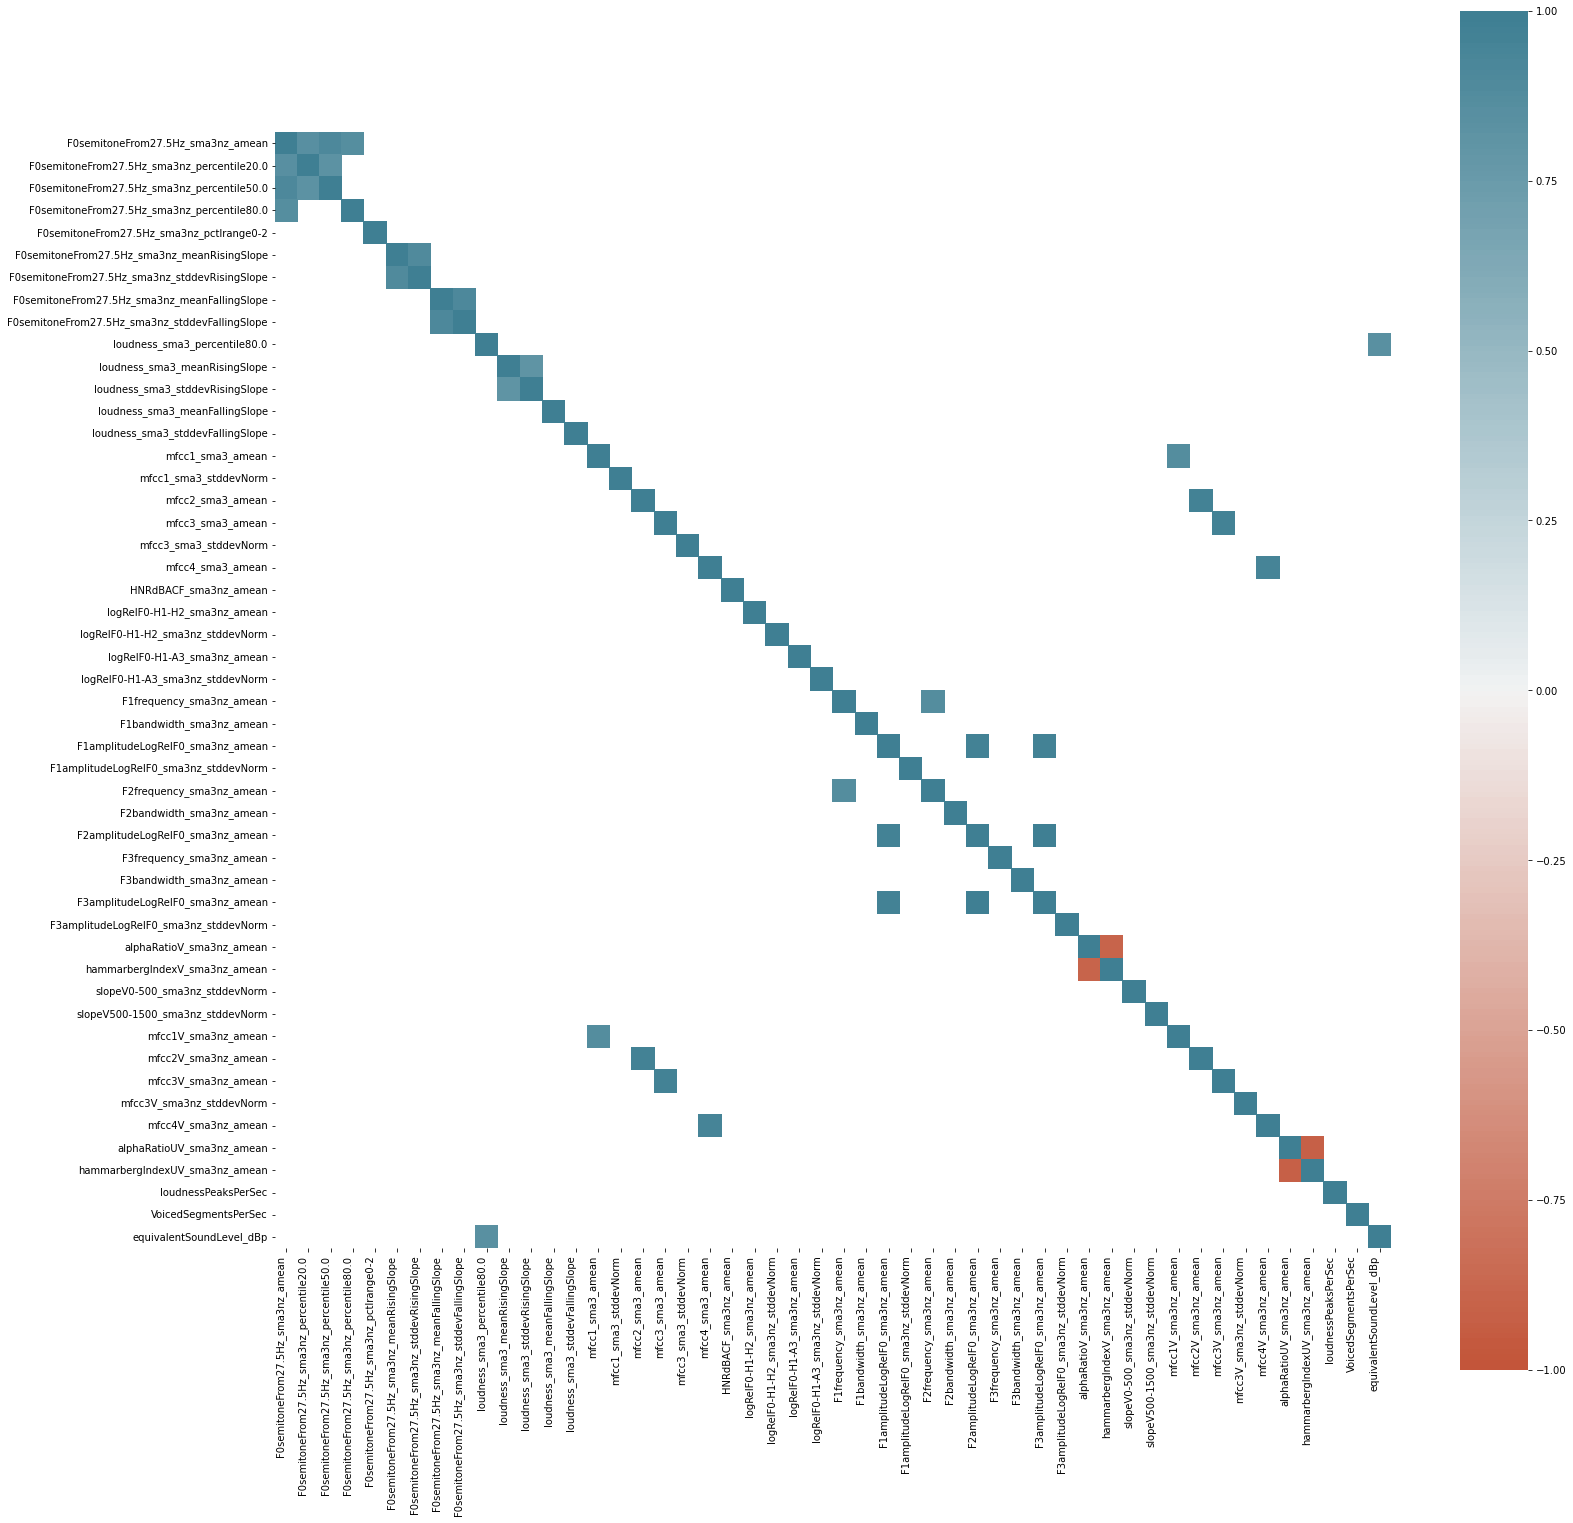

In [11]:
# only look up features with a correlation greater than 0.8 
plot_corr(opensmile_feature_labeled_df_filter_by_variancefilter, 0.8, "corr_gemaps.png")

In [12]:
opensmile_feature_labeled_df_filter_by_variancefilter.loc[:, 'mfcc1_1V_sma3_amean']  = get_mean_related_feature(opensmile_feature_labeled_df_filter_by_variancefilter,['mfcc1_sma3_amean','mfcc1V_sma3nz_amean'])
opensmile_feature_labeled_df_filter_by_variancefilter.loc[:, 'mfcc1_2V_sma3_amean']  = get_mean_related_feature(opensmile_feature_labeled_df_filter_by_variancefilter,['mfcc2_sma3_amean','mfcc2V_sma3nz_amean'])
opensmile_feature_labeled_df_filter_by_variancefilter.loc[:, 'mfcc1_3V_sma3_amean']  = get_mean_related_feature(opensmile_feature_labeled_df_filter_by_variancefilter,['mfcc3_sma3_amean','mfcc3V_sma3nz_amean'])
opensmile_feature_labeled_df_filter_by_variancefilter.loc[:, 'mfcc1_4V_sma3_amean']  = get_mean_related_feature(opensmile_feature_labeled_df_filter_by_variancefilter,['mfcc4_sma3_amean','mfcc4V_sma3nz_amean'])
opensmile_feature_labeled_df_filter_by_variancefilter.loc[:, 'F1F2frequency_sma3nz_amean']  = get_mean_related_feature(opensmile_feature_labeled_df_filter_by_variancefilter,['F1frequency_sma3nz_amean','F2frequency_sma3nz_amean'])
opensmile_feature_labeled_df_filter_by_variancefilter.loc[:, 'F1F2F3amplitudeLogRelF0_sma3nz_amean']  = get_mean_related_feature(opensmile_feature_labeled_df_filter_by_variancefilter,['F2amplitudeLogRelF0_sma3nz_amean','F1amplitudeLogRelF0_sma3nz_amean','F3amplitudeLogRelF0_sma3nz_amean'])

redundant_feature = ['F2frequency_sma3nz_amean','F1frequency_sma3nz_amean','F0semitoneFrom27.5Hz_sma3nz_percentile20.0','F0semitoneFrom27.5Hz_sma3nz_percentile50.0','F0semitoneFrom27.5Hz_sma3nz_percentile80.0','F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope','F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope','F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope', 'mfcc1_sma3_amean','mfcc1V_sma3nz_amean', 'mfcc2_sma3_amean','mfcc2V_sma3nz_amean', 'mfcc3_sma3_amean','mfcc3V_sma3nz_amean', 'mfcc4_sma3_amean','mfcc4V_sma3nz_amean','F2amplitudeLogRelF0_sma3nz_amean', 'F1amplitudeLogRelF0_sma3nz_amean', 'F3amplitudeLogRelF0_sma3nz_amean']
opensmile_feature_labeled_df_filter_by_corr_filter = drop_features(opensmile_feature_labeled_df_filter_by_variancefilter, redundant_feature)
opensmile_feature_labeled_df_filter_by_corr_filter


,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,loudness_sma3_percentile80.0,loudness_sma3_meanRisingSlope,loudness_sma3_stddevRisingSlope,loudness_sma3_meanFallingSlope,loudness_sma3_stddevFallingSlope,mfcc1_sma3_stddevNorm,...,hammarbergIndexUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,equivalentSoundLevel_dBp,mfcc1_1V_sma3_amean,mfcc1_2V_sma3_amean,mfcc1_3V_sma3_amean,mfcc1_4V_sma3_amean,F1F2frequency_sma3nz_amean,F1F2F3amplitudeLogRelF0_sma3nz_amean
0,24.644320,14.986946,69.717270,95.985023,1.536774,17.562607,1.810925,3.513810,5.309202,3.365518,...,2.297280,3.125000,3.125000,-19.766531,17.992332,9.097055,7.315771,0.575236,1178.250610,-119.956268
1,32.058033,1.984493,437.107422,53.106037,1.861136,14.580990,4.855892,6.406258,1.837494,0.181810,...,28.450947,2.083333,2.083333,-24.255608,36.349312,12.273380,-6.813425,-11.179138,886.631958,-43.339233
2,25.294464,1.512083,295.617889,-24.522924,1.218747,7.863028,5.895660,7.209478,4.233790,0.736528,...,14.053917,3.125000,2.083333,-21.970459,31.577377,24.586559,6.786629,-8.973932,1113.911011,-80.590332
3,26.988161,2.909376,34.296566,10.020885,2.521409,8.039275,3.599827,7.601770,6.008915,0.127143,...,0.000000,2.083333,1.041667,-16.260853,39.316689,8.448093,3.734077,-4.028117,846.013062,-11.640460
4,29.874161,8.545534,196.713745,18.160782,3.338323,25.536428,9.451651,26.063940,10.009459,0.400619,...,27.798044,3.125000,2.083333,-18.288975,30.661060,-15.387438,-6.432531,-26.320522,1120.868408,-42.398762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,44.153702,1.617435,27.978243,12.290778,3.423368,26.928200,18.546936,16.968607,9.045274,1.627945,...,9.117850,4.166667,3.125000,-20.099302,11.536142,-16.955542,-13.004391,-0.466267,1020.779175,-90.133400
196,39.183163,1.288013,6.465807,6.288173,0.587842,4.916765,2.527555,4.069522,1.574216,0.282766,...,43.126232,6.250000,2.083333,-32.965702,36.469482,2.118933,8.272384,-3.992403,979.832153,-38.946964
197,42.312115,1.423103,0.305290,0.000000,0.959487,1.357191,2.338041,14.284385,0.000000,2.188682,...,12.222716,1.041667,1.041667,-26.812983,4.329149,6.305231,2.496137,3.192318,1149.739990,-191.497635
198,35.837528,4.110958,1.703923,10.335389,2.885731,18.134245,6.270067,11.778662,10.621289,0.515000,...,10.121168,5.208333,2.083333,-21.693762,21.938915,-5.790648,-0.680401,-15.400103,953.301880,-19.856245


In [13]:
opensmile_feature_labeled_df_filter_by_variancefilter_subjective = add_class_label(opensmile_feature_labeled_df_filter_by_corr_filter, labeled_data_final, 'subjective')
opensmile_feature_labeled_df_filter_by_variancefilter_entertaining = add_class_label(opensmile_feature_labeled_df_filter_by_corr_filter, labeled_data_final, 'entertaining')
opensmile_feature_labeled_df_filter_by_variancefilter_discussion = add_class_label(opensmile_feature_labeled_df_filter_by_corr_filter, labeled_data_final, 'discussion')

In [14]:
# subjective
columns_pearsonr_selected_subjective = pearsonr_feature_filter(opensmile_feature_labeled_df_filter_by_corr_filter,opensmile_feature_labeled_df_filter_by_variancefilter_subjective.label,7)
# discussion
columns_pearsonr_selected_discussion = pearsonr_feature_filter(opensmile_feature_labeled_df_filter_by_corr_filter,opensmile_feature_labeled_df_filter_by_variancefilter_discussion.label,7)
# entertaining
columns_pearsonr_selected_entertaining = pearsonr_feature_filter(opensmile_feature_labeled_df_filter_by_corr_filter,opensmile_feature_labeled_df_filter_by_variancefilter_entertaining.label,7)

opensmile_feature_labeled_df_filter_by_pearsonr_subjective = select_features(opensmile_feature_labeled_df_filter_by_corr_filter,opensmile_feature_labeled_df_filter_by_corr_filter.columns[columns_pearsonr_selected_subjective])
opensmile_feature_labeled_df_filter_by_pearsonr_discussion = select_features(opensmile_feature_labeled_df_filter_by_corr_filter,opensmile_feature_labeled_df_filter_by_corr_filter.columns[columns_pearsonr_selected_discussion])
opensmile_feature_labeled_df_filter_by_pearsonr_entertaining = select_features(opensmile_feature_labeled_df_filter_by_corr_filter,opensmile_feature_labeled_df_filter_by_corr_filter.columns[columns_pearsonr_selected_entertaining])

In [15]:
# Min Max Scaler
opensmile_feature_labeled_df_filter_by_corr_filter_Minmaxscaler = min_max_scaler(opensmile_feature_labeled_df_filter_by_corr_filter)

# subjective
columns_chi_selected_subjective = chi_feature_filter(opensmile_feature_labeled_df_filter_by_corr_filter_Minmaxscaler,opensmile_feature_labeled_df_filter_by_variancefilter_subjective.label,7)
# discussion
columns_chi_selected_discussion = chi_feature_filter(opensmile_feature_labeled_df_filter_by_corr_filter_Minmaxscaler,opensmile_feature_labeled_df_filter_by_variancefilter_discussion.label,7)
# entertaining
columns_chi_selected_entertaining = chi_feature_filter(opensmile_feature_labeled_df_filter_by_corr_filter_Minmaxscaler,opensmile_feature_labeled_df_filter_by_variancefilter_entertaining.label,7)

opensmile_feature_labeled_df_filter_by_chi_subjective = select_features(opensmile_feature_labeled_df_filter_by_corr_filter, opensmile_feature_labeled_df_filter_by_corr_filter.columns[columns_chi_selected_subjective])
opensmile_feature_labeled_df_filter_by_chi_discussion = select_features(opensmile_feature_labeled_df_filter_by_corr_filter, opensmile_feature_labeled_df_filter_by_corr_filter.columns[columns_chi_selected_discussion])
opensmile_feature_labeled_df_filter_by_chi_entertaining = select_features(opensmile_feature_labeled_df_filter_by_corr_filter, opensmile_feature_labeled_df_filter_by_corr_filter.columns[columns_chi_selected_entertaining])

In [16]:
opensmile_feature_subjective = get_distinct_feature(opensmile_feature_labeled_df_filter_by_pearsonr_subjective, opensmile_feature_labeled_df_filter_by_chi_subjective)
opensmile_feature_discussion = get_distinct_feature(opensmile_feature_labeled_df_filter_by_pearsonr_discussion, opensmile_feature_labeled_df_filter_by_chi_discussion)
opensmile_feature_entertaining = get_distinct_feature(opensmile_feature_labeled_df_filter_by_pearsonr_entertaining, opensmile_feature_labeled_df_filter_by_chi_entertaining)

In [17]:
opensmile_feature_subjective

{'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope',
 'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2',
 'F1F2F3amplitudeLogRelF0_sma3nz_amean',
 'VoicedSegmentsPerSec',
 'alphaRatioUV_sma3nz_amean',
 'alphaRatioV_sma3nz_amean',
 'hammarbergIndexUV_sma3nz_amean',
 'logRelF0-H1-A3_sma3nz_stddevNorm',
 'loudness_sma3_meanRisingSlope',
 'loudness_sma3_percentile80.0',
 'mfcc1_sma3_stddevNorm'}

In [18]:
opensmile_feature_discussion

{'F0semitoneFrom27.5Hz_sma3nz_amean',
 'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope',
 'F1F2F3amplitudeLogRelF0_sma3nz_amean',
 'F1F2frequency_sma3nz_amean',
 'F3bandwidth_sma3nz_amean',
 'alphaRatioUV_sma3nz_amean',
 'hammarbergIndexUV_sma3nz_amean',
 'loudnessPeaksPerSec',
 'loudness_sma3_stddevRisingSlope',
 'mfcc1_3V_sma3_amean',
 'slopeV500-1500_sma3nz_stddevNorm'}

In [19]:
opensmile_feature_entertaining

{'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope',
 'F1F2frequency_sma3nz_amean',
 'F3frequency_sma3nz_amean',
 'VoicedSegmentsPerSec',
 'equivalentSoundLevel_dBp',
 'logRelF0-H1-A3_sma3nz_amean',
 'loudness_sma3_percentile80.0',
 'loudness_sma3_stddevFallingSlope',
 'mfcc1_1V_sma3_amean',
 'mfcc3V_sma3nz_stddevNorm'}

### YAMNet

In [20]:
yamnet_feature_labeled_df_subjective = add_class_label(yamnet_feature_labeled_df, labeled_data_final, 'subjective')
yamnet_feature_labeled_df_entertaining = add_class_label(yamnet_feature_labeled_df, labeled_data_final, 'entertaining')
yamnet_feature_labeled_df_discussion = add_class_label(yamnet_feature_labeled_df, labeled_data_final, 'discussion')

In [21]:
# subjective
columns_gbdt_selected_subjective = gbdt_feature_selection(yamnet_feature_labeled_df, yamnet_feature_labeled_df_subjective.label)
# discussion
columns_gbdt_selected_discussion = gbdt_feature_selection(yamnet_feature_labeled_df, yamnet_feature_labeled_df_discussion.label)
# entertaining
columns_gbdt_selected_entertaining = gbdt_feature_selection(yamnet_feature_labeled_df, yamnet_feature_labeled_df_entertaining.label)

yamnet_feature_labeled_df_gbdt_subjective = select_features(yamnet_feature_labeled_df, yamnet_feature_labeled_df.columns[columns_gbdt_selected_subjective])
yamnet_feature_labeled_df_gbdt_discussion = select_features(yamnet_feature_labeled_df, yamnet_feature_labeled_df.columns[columns_gbdt_selected_discussion])
yamnet_feature_labeled_df_gbdt_entertaining = select_features(yamnet_feature_labeled_df, yamnet_feature_labeled_df.columns[columns_gbdt_selected_entertaining])

In [22]:
# subjective
columns_rfe_SVM_selected_subjective = rfe_feature_selection('SVM', 15, yamnet_feature_labeled_df_gbdt_subjective, yamnet_feature_labeled_df_subjective.label)
# discussion
columns_rfe_SVM_selected_discussion = rfe_feature_selection('SVM', 15, yamnet_feature_labeled_df_gbdt_discussion, yamnet_feature_labeled_df_discussion.label)
# entertaining
columns_rfe_SVM_selected_entertaining = rfe_feature_selection('SVM', 15, yamnet_feature_labeled_df_gbdt_entertaining, yamnet_feature_labeled_df_entertaining.label)

# subjective
columns_rfe_LR_selected_subjective = rfe_feature_selection('LR', 15, yamnet_feature_labeled_df_gbdt_subjective, yamnet_feature_labeled_df_subjective.label)
# discussion
columns_rfe_LR_selected_discussion = rfe_feature_selection('LR', 15, yamnet_feature_labeled_df_gbdt_discussion, yamnet_feature_labeled_df_discussion.label)
# entertaining
columns_rfe_LR_selected_entertaining = rfe_feature_selection('LR', 15, yamnet_feature_labeled_df_gbdt_entertaining, yamnet_feature_labeled_df_entertaining.label)


yamnet_feature_labeled_df_filter_by_rfe_SVM_subjective = select_features(yamnet_feature_labeled_df_gbdt_subjective, yamnet_feature_labeled_df_gbdt_subjective.columns[columns_rfe_SVM_selected_subjective])
yamnet_feature_labeled_df_filter_by_rfe_SVM_discussion = select_features(yamnet_feature_labeled_df_gbdt_discussion, yamnet_feature_labeled_df_gbdt_discussion.columns[columns_rfe_SVM_selected_discussion])
yamnet_feature_labeled_df_filter_by_rfe_SVM_entertaining = select_features(yamnet_feature_labeled_df_gbdt_entertaining, yamnet_feature_labeled_df_gbdt_entertaining.columns[columns_rfe_SVM_selected_entertaining])

yamnet_feature_labeled_df_filter_by_rfe_LR_subjective = select_features(yamnet_feature_labeled_df_gbdt_subjective, yamnet_feature_labeled_df_gbdt_subjective.columns[columns_rfe_LR_selected_subjective])
yamnet_feature_labeled_df_filter_by_rfe_LR_discussion = select_features(yamnet_feature_labeled_df_gbdt_discussion, yamnet_feature_labeled_df_gbdt_discussion.columns[columns_rfe_LR_selected_discussion])
yamnet_feature_labeled_df_filter_by_rfe_LR_entertaining = select_features(yamnet_feature_labeled_df_gbdt_entertaining, yamnet_feature_labeled_df_gbdt_entertaining.columns[columns_rfe_LR_selected_entertaining])

In [23]:
yamnet_feature_subjective = get_distinct_feature(yamnet_feature_labeled_df_filter_by_rfe_SVM_subjective, yamnet_feature_labeled_df_filter_by_rfe_LR_subjective)
yamnet_feature_discussion = get_distinct_feature(yamnet_feature_labeled_df_filter_by_rfe_SVM_discussion, yamnet_feature_labeled_df_filter_by_rfe_LR_discussion)
yamnet_feature_entertaining = get_distinct_feature(yamnet_feature_labeled_df_filter_by_rfe_LR_entertaining, yamnet_feature_labeled_df_filter_by_rfe_LR_entertaining)

In [24]:
yamnet_feature_subjective,len(yamnet_feature_subjective)

({'Bicycle',
  'Conversation',
  'Inside, large room or hall',
  'Inside, small room',
  'Laughter',
  'Motor vehicle (road)',
  'Music',
  'Narration, monologue',
  'Outside, rural or natural',
  'Outside, urban or manmade',
  'Plop',
  'Speech',
  'Speech synthesizer',
  'Vehicle',
  'Writing'},
 15)

In [25]:
yamnet_feature_discussion,len(yamnet_feature_discussion)

({'Beatboxing',
  'Car',
  'Clip-clop',
  'Groan',
  'Inside, small room',
  'Livestock, farm animals, working animals',
  'Music',
  'Music for children',
  'Narration, monologue',
  'Outside, rural or natural',
  'Outside, urban or manmade',
  'Pig',
  'Radio',
  'Rhythm and blues',
  'Speech',
  'Speech synthesizer',
  'Vehicle'},
 17)

In [26]:
yamnet_feature_entertaining,len(yamnet_feature_entertaining)

({'Animal',
  'Chant',
  'Child speech, kid speaking',
  'Chuckle, chortle',
  'Gurgling',
  'Idling',
  'Inside, small room',
  'Mantra',
  'Music',
  'Narration, monologue',
  'Screaming',
  'Speech',
  'Speech synthesizer',
  'Vehicle',
  'Writing'},
 15)

# data preprocessing

### add label

In [27]:
# multi classification
subjective_label_final = []
i = 0


subjective_label_tmp = multi_class_add_label(subjective_label)
length = len(subjective_label_tmp)

while i < length:
    if subjective_label_tmp[i] =='Disapproval, Approval':
        subjective_label_tmp[i] = 'Approval, Disapproval'
    i += 1    

subjective_label_tmp = np.array(subjective_label_tmp)

for elem in subjective_label_tmp:
    if elem == '':
        subjective_label_final.append(1)
    elif elem == 'Disapproval':
        subjective_label_final.append(2)
    elif elem == 'Approval':
        subjective_label_final.append(3) 
    elif elem == 'Approval, Disapproval':
        subjective_label_final.append(4) 
        
# binary_classification       
discussion_label_final = binary_class_add_label(discussion_label, 'conversation')
entertaining_label_final = binary_class_add_label(entertaining_label, 'storytelling')

### eGeMAPs + YAMNet

In [28]:
opensmile_yamnet_features_df_subjective = pd.concat([select_features(yamnet_feature_labeled_df, list(yamnet_feature_subjective)), select_features(opensmile_feature_labeled_df_filter_by_corr_filter, list(opensmile_feature_subjective))], axis = 1)
opensmile_yamnet_features_df_discussion = pd.concat([select_features(yamnet_feature_labeled_df, list(yamnet_feature_discussion)), select_features(opensmile_feature_labeled_df_filter_by_corr_filter, list(opensmile_feature_discussion))], axis = 1)
opensmile_yamnet_features_df_entertaining = pd.concat([select_features(yamnet_feature_labeled_df, list(yamnet_feature_entertaining)), select_features(opensmile_feature_labeled_df_filter_by_corr_filter, list(opensmile_feature_entertaining))], axis = 1)

In [29]:
#subjective
opensmile_yamnet_feature_subjective_raw, opensmile_yamnet_feature_subjective_minmax, opensmile_yamnet_feature_subjective_minmax_standar = raw_minmax_stand(opensmile_yamnet_features_df_subjective, subjective_label_final)
#discussion
opensmile_yamnet_feature_discussion_raw, opensmile_yamnet_feature_discussion_minmax, opensmile_yamnet_feature_discussion_minmax_standar = raw_minmax_stand(opensmile_yamnet_features_df_discussion, discussion_label_final)
#entertaining
opensmile_yamnet_feature_entertaining_raw, opensmile_yamnet_feature_entertaining_minmax, opensmile_yamnet_feature_entertaining_minmax_standar = raw_minmax_stand(opensmile_yamnet_features_df_entertaining, entertaining_label_final)

##### Split the train set and test set

In [30]:
# eGeMAPs + YAMNet
# subjective
X_train_opensmile_yamnet_subjective, X_test_opensmile_yamnet_subjective, y_train_opensmile_yamnet_subjective, y_test_opensmile_yamnet_subjective = split_train_test_set(opensmile_yamnet_feature_subjective_minmax_standar, subjective_label_final, 0.25)
# discussion
X_train_opensmile_yamnet_discussion, X_test_opensmile_yamnet_discussion, y_train_opensmile_yamnet_discussion, y_test_opensmile_yamnet_discussion = split_train_test_set(opensmile_yamnet_feature_discussion_minmax_standar, discussion_label_final, 0.25)
# entertaining
X_train_opensmile_yamnet_entertaining, X_test_opensmile_yamnet_entertaining, y_train_opensmile_yamnet_entertaining, y_test_opensmile_yamnet_entertaining = split_train_test_set(opensmile_yamnet_feature_entertaining_minmax_standar, entertaining_label_final, 0.25)

### optional parameters

In [31]:
# KNN params for grid search
param_grid_knn = dict(n_neighbors=list(range(1,15)), weights=['uniform','distance'], algorithm=['auto','ball_tree','kd_tree','brute'], 
                      leaf_size=list(range(1,2)))
# SVM params for grid search
param_grid_svm = dict(gamma=['scale', 'auto'], C=[10, 100, 1000, 10000, 100000], kernel=['poly','rbf'])
# SGD params for grid search
param_grid_sgd ={'alpha':(0.001, 0.01, 0.1, 0.2), 'max_iter': (10000, 100000, 1000000), 
                 'loss':('hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'), 
                 'learning_rate':('constant', 'optimal', 'invscaling', 'adaptive')}
# RF params for grid search
param_grid_rf ={'n_estimators':range(10,71,5), 'criterion':('gini', 'entropy'), 'max_features':('auto', 'sqrt', 'log2'), 
                'class_weight' :('balanced', 'balanced_subsample')}

### Binary classification

### eGeMAPs + YAMNet

In [32]:
# KNN
knn_bestscore_opensmile_yamnet_discussion, knn_bestparams_opensmile_yamnet_discussion = choose_best_params('KNN', param_grid_knn, X_train_opensmile_yamnet_discussion, y_train_opensmile_yamnet_discussion)
knn_bestscore_opensmile_yamnet_entertaining, knn_bestparams_opensmile_yamnet_entertaining = choose_best_params('KNN', param_grid_knn, X_train_opensmile_yamnet_entertaining, y_train_opensmile_yamnet_entertaining)
# SVM
svm_bestscore_opensmile_yamnet_discussion, svm_bestparams_opensmile_yamnet_discussion = choose_best_params('SVM', param_grid_svm, X_train_opensmile_yamnet_discussion, y_train_opensmile_yamnet_discussion)
svm_bestscore_opensmile_yamnet_entertaining, svm_bestparams_opensmile_yamnet_entertaining = choose_best_params('SVM', param_grid_svm, X_train_opensmile_yamnet_entertaining, y_train_opensmile_yamnet_entertaining)
# SGD
sgd_bestscore_opensmile_yamnet_discussion, sgd_bestparams_opensmile_yamnet_discussion = choose_best_params('SGD', param_grid_sgd, X_train_opensmile_yamnet_discussion, y_train_opensmile_yamnet_discussion)
sgd_bestscore_opensmile_yamnet_entertaining, sgd_bestparams_opensmile_yamnet_entertaining = choose_best_params('SGD', param_grid_sgd, X_train_opensmile_yamnet_entertaining, y_train_opensmile_yamnet_entertaining)
# RF
rf_bestscore_opensmile_yamnet_discussion, rf_bestparams_opensmile_yamnet_discussion = choose_best_params('RF', param_grid_rf, X_train_opensmile_yamnet_discussion, y_train_opensmile_yamnet_discussion)
rf_bestscore_opensmile_yamnet_entertaining, rf_bestparams_opensmile_yamnet_entertaining = choose_best_params('RF', param_grid_rf, X_train_opensmile_yamnet_entertaining, y_train_opensmile_yamnet_entertaining)

##### discusion -- conversation

##### KNN

In [33]:
knn_bestscore_opensmile_yamnet_discussion, knn_bestparams_opensmile_yamnet_discussion

(0.72,
 {'algorithm': 'auto',
  'leaf_size': 1,
  'n_neighbors': 11,
  'weights': 'uniform'})

In [34]:
knn_binary_classifier(X_train_opensmile_yamnet_discussion, X_test_opensmile_yamnet_discussion, y_train_opensmile_yamnet_discussion, y_test_opensmile_yamnet_discussion, 11, 'uniform', 'auto', 1)

(array([0.73684211, 0.71052632, 0.72972973, 0.67567568]),
 array([[ 2, 17],
        [ 3, 28]]),
 0.7368421052631579,
 0.6222222222222222,
 0.9032258064516129,
 array([0.        , 0.21052632, 0.21052632, 0.63157895, 0.73684211,
        0.94736842, 1.        ]),
 array([0.        , 0.09677419, 0.25806452, 0.5483871 , 0.90322581,
        1.        , 1.        ]))

In [35]:
cross_score_discusion_knn, conf_mx_discusion_knn, f1_discusion_knn, p_discusion_knn, r_discusion_knn, fpr_discusion_knn, tpr_discusion_knn = knn_binary_classifier(X_train_opensmile_yamnet_discussion, X_test_opensmile_yamnet_discussion, y_train_opensmile_yamnet_discussion, y_test_opensmile_yamnet_discussion, 11, 'uniform', 'auto', 1)

##### SVM

In [36]:
svm_bestscore_opensmile_yamnet_discussion, svm_bestparams_opensmile_yamnet_discussion

(0.7066666666666667, {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'})

In [37]:
svm_binary_classifier(X_train_opensmile_yamnet_discussion, X_test_opensmile_yamnet_discussion, y_train_opensmile_yamnet_discussion, y_test_opensmile_yamnet_discussion, 'scale', 10, 'rbf')

(array([0.71052632, 0.68421053, 0.7027027 , 0.62162162]),
 array([[10,  9],
        [ 7, 24]]),
 0.7500000000000001,
 0.7272727272727273,
 0.7741935483870968,
 array([0.        , 0.        , 0.        , 0.10526316, 0.10526316,
        0.15789474, 0.15789474, 0.31578947, 0.31578947, 0.36842105,
        0.36842105, 0.42105263, 0.42105263, 0.47368421, 0.47368421,
        0.52631579, 0.52631579, 0.57894737, 0.57894737, 0.68421053,
        0.68421053, 0.78947368, 0.78947368, 1.        ]),
 array([0.        , 0.03225806, 0.25806452, 0.25806452, 0.35483871,
        0.35483871, 0.4516129 , 0.4516129 , 0.61290323, 0.61290323,
        0.74193548, 0.74193548, 0.80645161, 0.80645161, 0.83870968,
        0.83870968, 0.90322581, 0.90322581, 0.93548387, 0.93548387,
        0.96774194, 0.96774194, 1.        , 1.        ]))

In [38]:
cross_score_discusion_svm, conf_mx_discusion_svm, f1_discusion_svm, p_discusion_svm, r_discusion_svm, fpr_discusion_svm, tpr_discusion_svm = svm_binary_classifier(X_train_opensmile_yamnet_discussion, X_test_opensmile_yamnet_discussion, y_train_opensmile_yamnet_discussion, y_test_opensmile_yamnet_discussion, 'scale', 10, 'rbf')

##### SGD

In [39]:
sgd_bestscore_opensmile_yamnet_discussion, sgd_bestparams_opensmile_yamnet_discussion

(0.6933333333333332,
 {'alpha': 0.2,
  'learning_rate': 'optimal',
  'loss': 'squared_hinge',
  'max_iter': 10000})

In [40]:
sgd_binary_classifier(X_train_opensmile_yamnet_discussion, X_test_opensmile_yamnet_discussion, y_train_opensmile_yamnet_discussion, y_test_opensmile_yamnet_discussion, 10000000, 'log', 0.2, 'optimal')

(array([0.65789474, 0.52631579, 0.7027027 , 0.43243243]),
 array([[15,  4],
        [ 9, 22]]),
 0.7719298245614036,
 0.8461538461538461,
 0.7096774193548387,
 array([0.        , 0.        , 0.        , 0.05263158, 0.05263158,
        0.10526316, 0.10526316, 0.15789474, 0.15789474, 0.21052632,
        0.21052632, 0.26315789, 0.26315789, 0.31578947, 0.31578947,
        0.36842105, 0.36842105, 0.47368421, 0.47368421, 0.52631579,
        0.52631579, 0.57894737, 0.57894737, 1.        ]),
 array([0.        , 0.03225806, 0.12903226, 0.12903226, 0.48387097,
        0.48387097, 0.5483871 , 0.5483871 , 0.58064516, 0.58064516,
        0.70967742, 0.70967742, 0.74193548, 0.74193548, 0.77419355,
        0.77419355, 0.87096774, 0.87096774, 0.90322581, 0.90322581,
        0.93548387, 0.93548387, 1.        , 1.        ]))

In [41]:
cross_score_discusion_sgd, conf_mx_discusion_sgd, f1_discusion_sgd, p_discusion_sgd, r_discusion_sgd, fpr_discusion_sgd, tpr_discusion_sgd = sgd_binary_classifier(X_train_opensmile_yamnet_discussion, X_test_opensmile_yamnet_discussion, y_train_opensmile_yamnet_discussion, y_test_opensmile_yamnet_discussion, 10000000, 'log', 0.2, 'optimal')

##### RF

In [42]:
rf_bestscore_opensmile_yamnet_discussion, rf_bestparams_opensmile_yamnet_discussion

(0.7266666666666666,
 {'class_weight': 'balanced',
  'criterion': 'gini',
  'max_features': 'auto',
  'n_estimators': 15})

In [43]:
rf_binary_classifier(X_train_opensmile_yamnet_discussion, X_test_opensmile_yamnet_discussion, y_train_opensmile_yamnet_discussion, y_test_opensmile_yamnet_discussion, 'balanced', 'gini', 'auto', 50)

(array([0.68421053, 0.73684211, 0.7027027 , 0.81081081]),
 array([[ 3, 16],
        [ 5, 26]]),
 0.7123287671232876,
 0.6190476190476191,
 0.8387096774193549,
 array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.05263158, 0.05263158, 0.05263158, 0.15789474, 0.15789474,
        0.31578947, 0.47368421, 0.57894737, 0.78947368, 0.89473684,
        0.94736842, 1.        , 1.        ]),
 array([0.        , 0.03225806, 0.06451613, 0.12903226, 0.16129032,
        0.16129032, 0.25806452, 0.32258065, 0.35483871, 0.4516129 ,
        0.5483871 , 0.61290323, 0.70967742, 0.83870968, 0.83870968,
        0.90322581, 0.93548387, 1.        ]))

In [44]:
cross_score_discusion_rf, conf_mx_discusion_rf, f1_discusion_rf, p_discusion_rf, r_discusion_rf, fpr_discusion_rf, tpr_discusion_rf = rf_binary_classifier(X_train_opensmile_yamnet_discussion, X_test_opensmile_yamnet_discussion, y_train_opensmile_yamnet_discussion, y_test_opensmile_yamnet_discussion, 'balanced', 'gini', 'auto', 50)

##### entertaining -- storytelling

##### KNN

In [45]:
knn_bestscore_opensmile_yamnet_entertaining, knn_bestparams_opensmile_yamnet_entertaining

(0.5733333333333334,
 {'algorithm': 'auto',
  'leaf_size': 1,
  'n_neighbors': 13,
  'weights': 'uniform'})

In [46]:
knn_binary_classifier(X_train_opensmile_yamnet_entertaining, X_test_opensmile_yamnet_entertaining, y_train_opensmile_yamnet_entertaining, y_test_opensmile_yamnet_entertaining, 13, 'uniform', 'auto', 1)

(array([0.44736842, 0.52631579, 0.51351351, 0.59459459]),
 array([[ 7, 14],
        [ 9, 20]]),
 0.6349206349206349,
 0.5882352941176471,
 0.6896551724137931,
 array([0.        , 0.04761905, 0.0952381 , 0.14285714, 0.28571429,
        0.38095238, 0.61904762, 0.76190476, 0.9047619 , 1.        ]),
 array([0.        , 0.        , 0.06896552, 0.20689655, 0.34482759,
        0.68965517, 0.82758621, 0.86206897, 1.        , 1.        ]))

In [47]:
cross_score_entertaining_knn, conf_mx_entertaining_knn, f1_entertaining_knn, p_entertaining_knn, r_entertaining_knn, fpr_entertaining_knn, tpr_entertaining_knn = knn_binary_classifier(X_train_opensmile_yamnet_entertaining, X_test_opensmile_yamnet_entertaining, y_train_opensmile_yamnet_entertaining, y_test_opensmile_yamnet_entertaining, 13, 'uniform', 'auto', 1)

##### SVM

In [48]:
svm_bestscore_opensmile_yamnet_entertaining, svm_bestparams_opensmile_yamnet_entertaining

(0.6266666666666667, {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'})

In [49]:
svm_binary_classifier(X_train_opensmile_yamnet_entertaining, X_test_opensmile_yamnet_entertaining, y_train_opensmile_yamnet_entertaining, y_test_opensmile_yamnet_entertaining, 'auto', 10, 'rbf')

(array([0.55263158, 0.65789474, 0.59459459, 0.62162162]),
 array([[11, 10],
        [13, 16]]),
 0.5818181818181819,
 0.6153846153846154,
 0.5517241379310345,
 array([0.        , 0.        , 0.04761905, 0.04761905, 0.33333333,
        0.33333333, 0.38095238, 0.38095238, 0.42857143, 0.42857143,
        0.47619048, 0.47619048, 0.61904762, 0.61904762, 0.66666667,
        0.66666667, 0.71428571, 0.71428571, 0.80952381, 0.80952381,
        0.95238095, 0.95238095, 1.        ]),
 array([0.        , 0.03448276, 0.03448276, 0.27586207, 0.27586207,
        0.34482759, 0.34482759, 0.37931034, 0.37931034, 0.55172414,
        0.55172414, 0.62068966, 0.62068966, 0.72413793, 0.72413793,
        0.82758621, 0.82758621, 0.86206897, 0.86206897, 0.89655172,
        0.89655172, 1.        , 1.        ]))

In [50]:
cross_score_entertaining_svm, conf_mx_entertaining_svm, f1_entertaining_svm, p_entertaining_svm, r_entertaining_svm, fpr_entertaining_svm, tpr_entertaining_svm = svm_binary_classifier(X_train_opensmile_yamnet_entertaining, X_test_opensmile_yamnet_entertaining, y_train_opensmile_yamnet_entertaining, y_test_opensmile_yamnet_entertaining, 'auto', 10, 'rbf')

##### SGD

In [51]:
sgd_bestscore_opensmile_yamnet_entertaining, sgd_bestparams_opensmile_yamnet_entertaining

(0.6533333333333333,
 {'alpha': 0.01,
  'learning_rate': 'optimal',
  'loss': 'modified_huber',
  'max_iter': 100000})

In [52]:
sgd_binary_classifier(X_train_opensmile_yamnet_entertaining, X_test_opensmile_yamnet_entertaining, y_train_opensmile_yamnet_entertaining, y_test_opensmile_yamnet_entertaining, 10000000, 'log', 0.001, 'optimal')

(array([0.5       , 0.52631579, 0.62162162, 0.45945946]),
 array([[12,  9],
        [17, 12]]),
 0.48000000000000004,
 0.5714285714285714,
 0.41379310344827586,
 array([0.        , 0.        , 0.        , 0.0952381 , 0.0952381 ,
        0.19047619, 0.19047619, 0.33333333, 0.33333333, 0.42857143,
        0.42857143, 0.47619048, 0.47619048, 0.52380952, 0.52380952,
        0.57142857, 0.57142857, 0.61904762, 0.61904762, 0.71428571,
        0.71428571, 0.76190476, 0.76190476, 0.80952381, 0.80952381,
        0.85714286, 0.85714286, 0.9047619 , 0.9047619 , 1.        ,
        1.        ]),
 array([0.        , 0.03448276, 0.13793103, 0.13793103, 0.17241379,
        0.17241379, 0.27586207, 0.27586207, 0.37931034, 0.37931034,
        0.44827586, 0.44827586, 0.48275862, 0.48275862, 0.55172414,
        0.55172414, 0.65517241, 0.65517241, 0.72413793, 0.72413793,
        0.79310345, 0.79310345, 0.82758621, 0.82758621, 0.86206897,
        0.86206897, 0.89655172, 0.89655172, 0.93103448, 0.93103448,
 

In [53]:
cross_score_entertaining_sgd, conf_mx_entertaining_sgd, f1_entertaining_sgd, p_entertaining_sgd, r_entertaining_sgd, fpr_entertaining_sgd, tpr_entertaining_sgd = sgd_binary_classifier(X_train_opensmile_yamnet_entertaining, X_test_opensmile_yamnet_entertaining, y_train_opensmile_yamnet_entertaining, y_test_opensmile_yamnet_entertaining, 10000000, 'log', 0.001, 'optimal')

##### RF

In [54]:
rf_bestscore_opensmile_yamnet_entertaining, rf_bestparams_opensmile_yamnet_entertaining

(0.5466666666666666,
 {'class_weight': 'balanced',
  'criterion': 'gini',
  'max_features': 'sqrt',
  'n_estimators': 10})

In [55]:
rf_binary_classifier(X_train_opensmile_yamnet_entertaining, X_test_opensmile_yamnet_entertaining, y_train_opensmile_yamnet_entertaining, y_test_opensmile_yamnet_entertaining, 'balanced', 'gini', 'sqrt', 10)

(array([0.57894737, 0.63157895, 0.43243243, 0.62162162]),
 array([[10, 11],
        [13, 16]]),
 0.5714285714285714,
 0.5925925925925926,
 0.5517241379310345,
 array([0.        , 0.        , 0.04761905, 0.19047619, 0.38095238,
        0.57142857, 0.76190476, 0.9047619 , 0.95238095, 1.        ]),
 array([0.        , 0.10344828, 0.10344828, 0.17241379, 0.31034483,
        0.55172414, 0.82758621, 0.89655172, 0.93103448, 1.        ]))

In [56]:
cross_score_entertaining_rf, conf_mx_entertaining_rf, f1_entertaining_rf, p_entertaining_rf, r_entertaining_rf, fpr_entertaining_rf, tpr_entertaining_rf = rf_binary_classifier(X_train_opensmile_yamnet_entertaining, X_test_opensmile_yamnet_entertaining, y_train_opensmile_yamnet_entertaining, y_test_opensmile_yamnet_entertaining, 'balanced', 'gini', 'sqrt', 10)

### Multi classification

In [57]:
# KNN
knn_bestscore_opensmile_yamnet_subjective, knn_bestparams_opensmile_yamnet_subjective = choose_best_params('KNN', param_grid_knn, X_train_opensmile_yamnet_subjective, y_train_opensmile_yamnet_subjective)

# SVM
svm_bestscore_opensmile_yamnet_subjective, svm_bestparams_opensmile_yamnet_subjective = choose_best_params('SVM', param_grid_svm, X_train_opensmile_yamnet_subjective, y_train_opensmile_yamnet_subjective)

# SGD
sgd_bestscore_opensmile_yamnet_subjective, sgd_bestparams_opensmile_yamnet_subjective = choose_best_params('SGD', param_grid_sgd, X_train_opensmile_yamnet_subjective, y_train_opensmile_yamnet_subjective)

# RF
rf_bestscore_opensmile_yamnet_subjective, rf_bestparams_opensmile_yamnet_subjective = choose_best_params('RF', param_grid_rf, X_train_opensmile_yamnet_subjective, y_train_opensmile_yamnet_subjective)

##### KNN

In [58]:
knn_bestscore_opensmile_yamnet_subjective, knn_bestparams_opensmile_yamnet_subjective

(0.54,
 {'algorithm': 'auto',
  'leaf_size': 1,
  'n_neighbors': 14,
  'weights': 'uniform'})

In [59]:
knn_multi_classifier(X_train_opensmile_yamnet_subjective, X_test_opensmile_yamnet_subjective, y_train_opensmile_yamnet_subjective, y_test_opensmile_yamnet_subjective, 4, 'uniform', 'auto', 1)

(array([0.47368421, 0.55263158, 0.40540541, 0.48648649]),
 array([[12,  2, 10,  0],
        [ 3,  0,  2,  0],
        [12,  2,  6,  0],
        [ 1,  0,  0,  0]]),
 0.19433198380566802,
 0.19047619047619047,
 0.2,
 -0.1049723756906078)

In [60]:
cross_score_subjective_knn, conf_mx_subjective_knn, f1_subjective_knn, p_subjective_knn, r_subjective_knn, kappa_subjective_knn = knn_multi_classifier(X_train_opensmile_yamnet_subjective, X_test_opensmile_yamnet_subjective, y_train_opensmile_yamnet_subjective, y_test_opensmile_yamnet_subjective, 14, 'uniform', 'auto', 1)

##### SVM

In [61]:
svm_bestscore_opensmile_yamnet_subjective, svm_bestparams_opensmile_yamnet_subjective

(0.5333333333333334, {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'})

In [62]:
svm_multi_classifier(X_train_opensmile_yamnet_subjective, X_test_opensmile_yamnet_subjective, y_train_opensmile_yamnet_subjective, y_test_opensmile_yamnet_subjective, 'auto', 10, 'rbf')

(array([0.55263158, 0.47368421, 0.37837838, 0.48648649]),
 array([[10,  1, 13,  0],
        [ 2,  0,  3,  0],
        [10,  1,  9,  0],
        [ 1,  0,  0,  0]]),
 0.20638297872340425,
 0.19869565217391305,
 0.21666666666666667,
 -0.07788595271210008)

In [63]:
cross_score_subjective_svm, conf_mx_subjective_svm, f1_subjective_svm, p_subjective_svm, r_subjective_svm, kappa_subjective_svm = svm_multi_classifier(X_train_opensmile_yamnet_subjective, X_test_opensmile_yamnet_subjective, y_train_opensmile_yamnet_subjective, y_test_opensmile_yamnet_subjective, 'auto', 10, 'poly')

##### SGD

In [64]:
sgd_bestscore_opensmile_yamnet_subjective, sgd_bestparams_opensmile_yamnet_subjective

(0.5533333333333333,
 {'alpha': 0.2,
  'learning_rate': 'optimal',
  'loss': 'squared_hinge',
  'max_iter': 100000})

In [65]:
sgd_multi_classifier(X_train_opensmile_yamnet_subjective, X_test_opensmile_yamnet_subjective, y_train_opensmile_yamnet_subjective, y_test_opensmile_yamnet_subjective, 10000000, 'log', 0.2, 'optimal')

(array([0.57894737, 0.60526316, 0.43243243, 0.56756757]),
 array([[ 6,  5, 10,  3],
        [ 2,  0,  3,  0],
        [ 9,  5,  6,  0],
        [ 1,  0,  0,  0]]),
 0.14835164835164838,
 0.16228070175438597,
 0.1375,
 -0.1620795107033639)

In [66]:
cross_score_subjective_sgd, conf_mx_subjective_sgd, f1_subjective_sgd, p_subjective_sgd, r_subjective_sgd, kappa_subjective_sgd = sgd_multi_classifier(X_train_opensmile_yamnet_subjective, X_test_opensmile_yamnet_subjective, y_train_opensmile_yamnet_subjective, y_test_opensmile_yamnet_subjective, 10000000, 'log', 0.2, 'optimal')

##### RF

In [67]:
rf_bestscore_opensmile_yamnet_subjective, rf_bestparams_opensmile_yamnet_subjective

(0.5466666666666666,
 {'class_weight': 'balanced_subsample',
  'criterion': 'gini',
  'max_features': 'auto',
  'n_estimators': 15})

In [68]:
rf_multi_classifier(X_train_opensmile_yamnet_subjective, X_test_opensmile_yamnet_subjective, y_train_opensmile_yamnet_subjective, y_test_opensmile_yamnet_subjective, 'balanced_subsample', 'gini', 'auto', 15)

(array([0.5       , 0.47368421, 0.51351351, 0.62162162]),
 array([[ 7,  3, 14,  0],
        [ 3,  0,  2,  0],
        [ 9,  2,  9,  0],
        [ 1,  0,  0,  0]]),
 0.17954545454545456,
 0.1775,
 0.18541666666666667,
 -0.13712374581939812)

In [69]:
cross_score_subjective_rf, conf_mx_subjective_rf, f1_subjective_rf, p_subjective_rf, r_subjective_rf, kappa_subjective_rf = rf_multi_classifier(X_train_opensmile_yamnet_subjective, X_test_opensmile_yamnet_subjective, y_train_opensmile_yamnet_subjective, y_test_opensmile_yamnet_subjective, 'balanced_subsample', 'gini', 'auto', 15)

# Deep Learning

In [70]:
len(X_train_opensmile_yamnet_entertaining.columns), len(X_train_opensmile_yamnet_discussion.columns), len(X_train_opensmile_yamnet_subjective.columns)

(25, 28, 26)

In [128]:
entertaining_model = creat_binary_deep_learning_model(len(X_train_opensmile_yamnet_entertaining.columns), 1)
discussion_model = creat_binary_deep_learning_model(len(X_train_opensmile_yamnet_discussion.columns), 1)
subjective_model = creat_multi_deep_learning_model(len(X_train_opensmile_yamnet_subjective.columns), 5)

In [120]:
entertaining_model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_15 (Flatten)         (None, 25)                0         
_________________________________________________________________
dense_50 (Dense)             (None, 200)               5200      
_________________________________________________________________
dense_51 (Dense)             (None, 50)                10050     
_________________________________________________________________
dense_52 (Dense)             (None, 1)                 51        
Total params: 15,301
Trainable params: 15,301
Non-trainable params: 0
_________________________________________________________________


In [92]:
discussion_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 28)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 200)               5800      
_________________________________________________________________
dense_14 (Dense)             (None, 50)                10050     
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 51        
Total params: 15,901
Trainable params: 15,901
Non-trainable params: 0
_________________________________________________________________


In [93]:
subjective_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 26)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 500)               13500     
_________________________________________________________________
dense_17 (Dense)             (None, 300)               150300    
_________________________________________________________________
dense_18 (Dense)             (None, 100)               30100     
_________________________________________________________________
dense_19 (Dense)             (None, 5)                 505       
Total params: 194,405
Trainable params: 194,405
Non-trainable params: 0
_________________________________________________________________


In [129]:
entertaining_model.compile(loss = "binary_crossentropy", optimizer='sgd', metrics=["accuracy"])
discussion_model.compile(loss = "binary_crossentropy", optimizer='sgd', metrics=["accuracy"])
subjective_model.compile(loss = "categorical_crossentropy", optimizer='sgd', metrics=["accuracy"])

In [130]:
history_entertaining = entertaining_model.fit(X_train_opensmile_yamnet_entertaining, np.array(y_train_opensmile_yamnet_entertaining), epochs=60, validation_split=0.2)

Epoch 1/60
4/4 [==============================] - 1s 69ms/step - loss: 0.7411 - accuracy: 0.4781 - val_loss: 0.7026 - val_accuracy: 0.5333
Epoch 2/60
4/4 [==============================] - 0s 18ms/step - loss: 0.7258 - accuracy: 0.4917 - val_loss: 0.7010 - val_accuracy: 0.5000
Epoch 3/60
4/4 [==============================] - 0s 18ms/step - loss: 0.7082 - accuracy: 0.5587 - val_loss: 0.6994 - val_accuracy: 0.5000
Epoch 4/60
4/4 [==============================] - 0s 18ms/step - loss: 0.7182 - accuracy: 0.5110 - val_loss: 0.6979 - val_accuracy: 0.5000
Epoch 5/60
4/4 [==============================] - 0s 18ms/step - loss: 0.6943 - accuracy: 0.5381 - val_loss: 0.6962 - val_accuracy: 0.5000
Epoch 6/60
4/4 [==============================] - 0s 18ms/step - loss: 0.7071 - accuracy: 0.5173 - val_loss: 0.6951 - val_accuracy: 0.5000
Epoch 7/60
4/4 [==============================] - 0s 21ms/step - loss: 0.6927 - accuracy: 0.5552 - val_loss: 0.6937 - val_accuracy: 0.5000
Epoch 8/60
4/4 [===========

In [96]:
history_discussion = discussion_model.fit(X_train_opensmile_yamnet_discussion, np.array(y_train_opensmile_yamnet_discussion), epochs=40, validation_split=0.2)

Epoch 1/40
4/4 [==============================] - 1s 67ms/step - loss: 0.7520 - accuracy: 0.3577 - val_loss: 0.7499 - val_accuracy: 0.3667
Epoch 2/40
4/4 [==============================] - 0s 17ms/step - loss: 0.7373 - accuracy: 0.3777 - val_loss: 0.7341 - val_accuracy: 0.5000
Epoch 3/40
4/4 [==============================] - 0s 18ms/step - loss: 0.6948 - accuracy: 0.4865 - val_loss: 0.7208 - val_accuracy: 0.5667
Epoch 4/40
4/4 [==============================] - 0s 17ms/step - loss: 0.6880 - accuracy: 0.5577 - val_loss: 0.7102 - val_accuracy: 0.6000
Epoch 5/40
4/4 [==============================] - 0s 22ms/step - loss: 0.6664 - accuracy: 0.6619 - val_loss: 0.6998 - val_accuracy: 0.6667
Epoch 6/40
4/4 [==============================] - 0s 18ms/step - loss: 0.6612 - accuracy: 0.6698 - val_loss: 0.6904 - val_accuracy: 0.6667
Epoch 7/40
4/4 [==============================] - 0s 21ms/step - loss: 0.6535 - accuracy: 0.6790 - val_loss: 0.6828 - val_accuracy: 0.7000
Epoch 8/40
4/4 [===========

In [97]:
history_subjective = subjective_model.fit(X_train_opensmile_yamnet_subjective, tf.keras.utils.to_categorical(y_train_opensmile_yamnet_subjective), epochs=150, validation_split=0.2)

Epoch 1/150
4/4 [==============================] - 1s 100ms/step - loss: 1.5931 - accuracy: 0.2265 - val_loss: 1.5285 - val_accuracy: 0.4667
Epoch 2/150
4/4 [==============================] - 0s 16ms/step - loss: 1.5240 - accuracy: 0.4079 - val_loss: 1.4780 - val_accuracy: 0.5000
Epoch 3/150
4/4 [==============================] - 0s 25ms/step - loss: 1.4486 - accuracy: 0.5335 - val_loss: 1.4341 - val_accuracy: 0.5333
Epoch 4/150
4/4 [==============================] - 0s 27ms/step - loss: 1.4436 - accuracy: 0.5302 - val_loss: 1.3958 - val_accuracy: 0.5333
Epoch 5/150
4/4 [==============================] - 0s 19ms/step - loss: 1.3895 - accuracy: 0.5773 - val_loss: 1.3614 - val_accuracy: 0.5333
Epoch 6/150
4/4 [==============================] - 0s 18ms/step - loss: 1.3392 - accuracy: 0.5492 - val_loss: 1.3317 - val_accuracy: 0.5333
Epoch 7/150
4/4 [==============================] - 0s 18ms/step - loss: 1.3113 - accuracy: 0.5669 - val_loss: 1.3049 - val_accuracy: 0.5333
Epoch 8/150
4/4 [==

In [98]:
y_proba_opensmile_yamnet_entertaining = entertaining_model.predict_classes(X_test_opensmile_yamnet_entertaining)
y_proba_opensmile_yamnet_discussion= discussion_model.predict_classes(X_test_opensmile_yamnet_discussion)
y_proba_opensmile_yamnet_subjective = subjective_model.predict_classes(X_test_opensmile_yamnet_subjective)

In [132]:
acc_dl_entertaining, f1_dl_entertaining, pr_dl_entertaining, re_dl_entertaining = metrics_dl_model_binary(y_test_opensmile_yamnet_entertaining, y_proba_opensmile_yamnet_entertaining)
acc_dl_discussion, f1_dl_discussion, pr_dl_discussion, re_dl_discussion = metrics_dl_model_binary(y_test_opensmile_yamnet_discussion, y_proba_opensmile_yamnet_discussion)
f1_dl_subjective, pr_dl_subjective, re_dl_subjective, kappa_dl_subjective = metrics_dl_model_multi(y_test_opensmile_yamnet_subjective, y_proba_opensmile_yamnet_subjective)

In [133]:
print(f"accuarcy entertaining:{acc_dl_entertaining} \t f1 score entertaining:{f1_dl_entertaining} \t precision entertaining:{pr_dl_entertaining} \t recall entertaining:{re_dl_entertaining}")
print(f"accuarcy discussion:{acc_dl_discussion} \t f1 score discussion:{f1_dl_discussion} \t precision discussion:{pr_dl_discussion} \t recall discussion:{re_dl_discussion}")
print(f"kappa subjective:{kappa_dl_subjective} \t f1 score subjective:{f1_dl_subjective} \t precision subjective:{pr_dl_subjective} \t recall subjective:{re_dl_subjective}")

accuarcy entertaining:0.6 	 f1 score entertaining:0.6875 	 precision entertaining:0.6285714285714286 	 recall entertaining:0.7586206896551724
accuarcy discussion:0.62 	 f1 score discussion:0.7654320987654321 	 precision discussion:0.62 	 recall discussion:1.0
kappa subjective:0.1887905604719763 	 f1 score subjective:0.28431372549019607 	 precision subjective:0.28174603174603174 	 recall subjective:0.30833333333333335


# Performance comparison

### discusion -- conversation

In [82]:
print("discusion -- conversation metrics")
print(f"f1 score KNN:{f1_discusion_knn} \t precision KNN:{p_discusion_knn} \t recall KNN:{r_discusion_knn}")
print(f"f1 score SVM:{f1_discusion_svm} \t precision SVM:{p_discusion_svm} \t recall SVM:{r_discusion_svm}")
print(f"f1 score SGD:{f1_discusion_sgd} \t precision SGD:{p_discusion_sgd} \t recall SGD:{r_discusion_sgd}")
print(f"f1 score RF:{f1_discusion_rf} \t precision RF:{p_discusion_rf} \t recall RF:{r_discusion_rf}")

discusion -- conversation metrics
f1 score KNN:0.7368421052631579 	 precision KNN:0.6222222222222222 	 recall KNN:0.9032258064516129
f1 score SVM:0.7500000000000001 	 precision SVM:0.7272727272727273 	 recall SVM:0.7741935483870968
f1 score SGD:0.75 	 precision SGD:0.84 	 recall SGD:0.6774193548387096
f1 score RF:0.7222222222222222 	 precision RF:0.6341463414634146 	 recall RF:0.8387096774193549


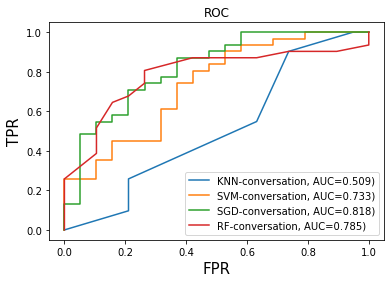

In [83]:
from sklearn.metrics import roc_curve, auc


# # plot all roc curve
plt.plot(fpr_discusion_knn, tpr_discusion_knn, lw=1.5, label="KNN-conversation, AUC=%.3f)"%auc(fpr_discusion_knn, tpr_discusion_knn))
plt.plot(fpr_discusion_svm, tpr_discusion_svm, lw=1.5, label="SVM-conversation, AUC=%.3f)"%auc(fpr_discusion_svm, tpr_discusion_svm) )
plt.plot(fpr_discusion_sgd, tpr_discusion_sgd, lw=1.5, label="SGD-conversation, AUC=%.3f)"%auc(fpr_discusion_sgd, tpr_discusion_sgd) )
plt.plot(fpr_discusion_rf, tpr_discusion_rf, lw=1.5, label="RF-conversation, AUC=%.3f)" %auc(fpr_discusion_rf, tpr_discusion_rf))

plt.xlabel("FPR",fontsize=15)
plt.ylabel("TPR",fontsize=15)

plt.title("ROC")
plt.legend(loc="lower right")
plt.savefig("roc_conversation.png",bbox_inches='tight')
plt.show()
    

### entertaining -- storytelling

In [84]:
print("entertaining -- storytelling metrics")
print(f"f1 score KNN:{f1_entertaining_knn} \t precision KNN:{p_entertaining_knn} \t recall KNN:{r_entertaining_knn}")
print(f"f1 score SVM:{f1_entertaining_svm} \t precision SVM:{p_entertaining_svm} \t recall SVM:{r_entertaining_svm}")
print(f"f1 score SGD:{f1_entertaining_sgd} \t precision SGD:{p_entertaining_sgd} \t recall SGD:{r_entertaining_sgd}")
print(f"f1 score RF:{f1_entertaining_rf} \t precision RF:{p_entertaining_rf} \t recall RF:{r_entertaining_rf}")

entertaining -- storytelling metrics
f1 score KNN:0.6349206349206349 	 precision KNN:0.5882352941176471 	 recall KNN:0.6896551724137931
f1 score SVM:0.5818181818181819 	 precision SVM:0.6153846153846154 	 recall SVM:0.5517241379310345
f1 score SGD:0.4150943396226415 	 precision SGD:0.4583333333333333 	 recall SGD:0.3793103448275862
f1 score RF:0.5714285714285714 	 precision RF:0.5925925925925926 	 recall RF:0.5517241379310345


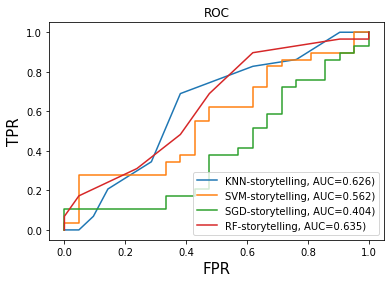

In [85]:
from sklearn.metrics import roc_curve, auc


# # plot all roc curve
plt.plot(fpr_entertaining_knn, tpr_entertaining_knn, lw=1.5, label="KNN-storytelling, AUC=%.3f)"%auc(fpr_entertaining_knn, tpr_entertaining_knn))
plt.plot(fpr_entertaining_svm, tpr_entertaining_svm, lw=1.5, label="SVM-storytelling, AUC=%.3f)"%auc(fpr_entertaining_svm, tpr_entertaining_svm) )
plt.plot(fpr_entertaining_sgd, tpr_entertaining_sgd, lw=1.5, label="SGD-storytelling, AUC=%.3f)"%auc(fpr_entertaining_sgd, tpr_entertaining_sgd) )
plt.plot(fpr_entertaining_rf, tpr_entertaining_rf, lw=1.5, label="RF-storytelling, AUC=%.3f)" %auc(fpr_entertaining_rf, tpr_entertaining_rf))

plt.xlabel("FPR",fontsize=15)
plt.ylabel("TPR",fontsize=15)

plt.title("ROC")
plt.legend(loc="lower right")
plt.savefig("roc_storytelling.png",bbox_inches='tight')
plt.show()
    

### subjective

In [86]:
print("discusion -- conversation metrics")
print(f"f1 score KNN:{f1_subjective_knn} \t precision KNN:{p_subjective_knn} \t recall KNN:{r_subjective_knn} \t kappa KNN:{kappa_subjective_knn}")
print(f"f1 score SVM:{f1_subjective_svm} \t precision SVM:{p_subjective_svm} \t recall SVM:{r_subjective_svm} \t kappa SVM:{kappa_subjective_svm}")
print(f"f1 score SGD:{f1_subjective_sgd} \t precision SGD:{p_subjective_sgd} \t recall SGD:{r_subjective_sgd} \t kappa SGD:{kappa_subjective_sgd}")
print(f"f1 score RF:{f1_subjective_rf} \t precision RF:{p_subjective_rf} \t recall RF:{r_subjective_rf} \t kappa RF:{kappa_subjective_rf}")

discusion -- conversation metrics
f1 score KNN:0.18611111111111112 	 precision KNN:0.175 	 recall KNN:0.2 	 kappa KNN:-0.1594202898550725
f1 score SVM:0.16911764705882354 	 precision SVM:0.15773809523809523 	 recall SVM:0.19375 	 kappa SVM:-0.1799410029498527
f1 score SGD:0.14669051878354206 	 precision SGD:0.15789473684210525 	 recall SGD:0.1375 	 kappa SGD:-0.1757425742574259
f1 score RF:0.22004830917874396 	 precision RF:0.21227272727272728 	 recall RF:0.23125 	 kappa RF:-0.026694045174538106


### plot ml model


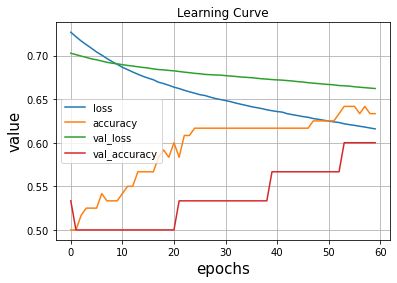

In [131]:
pd.DataFrame(history_entertaining.history).plot()
plt.grid(True)
plt.gca()
plt.xlabel("epochs",fontsize=15)
plt.ylabel("value",fontsize=15)

plt.title("Learning Curve")
plt.savefig("learning_curve_entertaining.png",bbox_inches='tight')
plt.show()

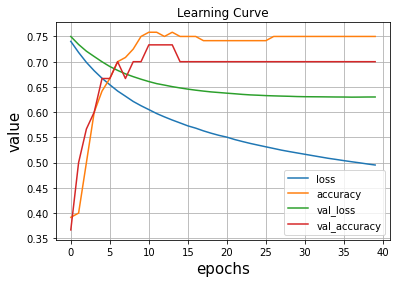

In [102]:
pd.DataFrame(history_discussion.history).plot()
plt.grid(True)
plt.gca()
plt.xlabel("epochs",fontsize=15)
plt.ylabel("value",fontsize=15)

plt.title("Learning Curve")
plt.savefig("learning_curve_discussion.png",bbox_inches='tight')
plt.show()

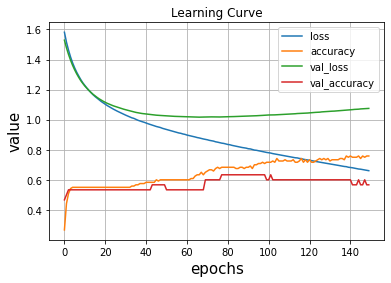

In [103]:
pd.DataFrame(history_subjective.history).plot()
plt.grid(True)
plt.gca()
plt.xlabel("epochs",fontsize=15)
plt.ylabel("value",fontsize=15)

plt.title("Learning Curve")
plt.savefig("learning_curve_subjective.png",bbox_inches='tight')
plt.show()